In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm
import warnings
from category_encoders import TargetEncoder

# Ignorer les avertissements de dépassement de capacité et de division par zéro
warnings.filterwarnings("ignore")

In [77]:
df_cat = pd.read_csv('./data/data_categorielles (1).csv')
df_num = pd.read_csv('./data/var_num.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

In [78]:
df2 = df_app[['WALLSMATERIAL_MODE',
'HOUSETYPE_MODE',
'EMERGENCYSTATE_MODE',
'OCCUPATION_TYPE','OWN_CAR_AGE',
'EXT_SOURCE_1',
'YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BEGINEXPLUATATION_AVG']]

In [79]:
data = pd.concat([df_num,df_cat,df2],axis = 1)
data['date'] = df_app['date_mensuelle'].copy()
data['date'] = pd.to_datetime(data['date'])
data.drop(columns = ['Unnamed: 0','NAME_HOUSING_TYPE','AMT_ANNUITY_disc_int'],inplace = True)
data['CODE_GENDER'] = data['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)

In [80]:
list_mean = []
liste_freq = []

# Calcul des moyennes et des fréquences
for cat in df_app['OCCUPATION_TYPE'].unique():
    moyenne = df_app.loc[df_app['OCCUPATION_TYPE'] == cat, 'TARGET'].mean()
    freq = round(df_app[df_app['OCCUPATION_TYPE'] == cat].shape[0]/data.shape[0]*100,1)
    list_mean.append(moyenne)
    liste_freq.append(freq)
    
# Création du DataFrame CP
CP = pd.DataFrame({'mean': list_mean, 'freq': liste_freq, 'OCCUPATION_TYPE': data['OCCUPATION_TYPE'].unique()})
precaire = CP[CP['mean']>0.099]['OCCUPATION_TYPE']


data['OCCUPATION_TYPE'] = np.where(data['OCCUPATION_TYPE'].isin(precaire), 'Mauvais type', 'Bon type')


In [81]:
X = data.drop(columns = ['SK_ID_CURR'], axis=1).copy()
X = X[X['date']<'2020-01-01']
y = data[data['date']<'2020-01-01']['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train.drop(columns = 'TARGET',inplace =True)
X_test.drop(columns = 'TARGET',inplace =True)

In [84]:
data.drop(columns = ['SK_ID_CURR','TARGET']).select_dtypes(include ='number').columns

Index(['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'FLAG_PHONE',
       'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'OWN_CAR_AGE',
       'EXT_SOURCE_1', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG'],
      dtype='object')

In [87]:

liste_gini = []

for col in data.drop(columns = ['SK_ID_CURR','TARGET']).select_dtypes(include ='number').columns : 
    # NaN
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)
    # Constante
    X_train_scaled = X_train[col]
    X_test_scaled = X_test[col]
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    # Fit 
    model = sm.Logit(y_train, X_train_scaled)
    result = model.fit_regularized(method='l1', disp=False)
    
    # Pred
    y_pred = result.predict(X_test_scaled)
    y_pred = (y_pred > 0.5).astype(int)
    
    y_prob = result.predict(X_test_scaled)
    
    # Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Calculer le coefficient de Gini
    gini_coefficient = 2 * roc_auc - 1
    liste_gini.append(gini_coefficient)
    print(f'{col} gini : {gini_coefficient}')
df_selec_var_num = pd.DataFrame(liste_gini,index = data.drop(columns = ['SK_ID_CURR','TARGET']).select_dtypes(include ='number').columns, columns =['Gini'] )

REGION_RATING_CLIENT_W_CITY gini : 0.1002639857983958
REGION_RATING_CLIENT gini : 0.09586979337717971
FLAG_PHONE gini : 0.044516028673380115
LIVE_CITY_NOT_WORK_CITY gini : 0.04101127095596491
REG_CITY_NOT_LIVE_CITY gini : 0.05134579899698344
REG_CITY_NOT_WORK_CITY gini : 0.08616948591375251
FLAG_EMP_PHONE gini : 0.0577214498634655
OWN_CAR_AGE gini : -0.03329594247365297
EXT_SOURCE_1 gini : 0.09017378393423225
YEARS_BEGINEXPLUATATION_MEDI gini : 0.0967034631886936
YEARS_BEGINEXPLUATATION_MODE gini : 0.09608908518183723
YEARS_BEGINEXPLUATATION_AVG gini : 0.09669418717007949


In [88]:
df_app[df_selec_var_num[df_selec_var_num['Gini']>0.05].index.to_list()].isna().sum()

REGION_RATING_CLIENT_W_CITY          0
REGION_RATING_CLIENT                 0
REG_CITY_NOT_LIVE_CITY               0
REG_CITY_NOT_WORK_CITY               0
FLAG_EMP_PHONE                       0
EXT_SOURCE_1                    172564
YEARS_BEGINEXPLUATATION_MEDI    149238
YEARS_BEGINEXPLUATATION_MODE    149238
YEARS_BEGINEXPLUATATION_AVG     149238
dtype: int64

In [90]:

liste_gini = []

for col in data.drop(columns = ['SK_ID_CURR','TARGET']).select_dtypes(include ='object').columns : 
    # NaN
    mode = X_train[col].mode()
    X_train[col] = X_train[col].fillna(mode)
    X_test[col] = X_test[col].fillna(mode)
    
    # Encoding
    target_encoder = TargetEncoder()
    target_encoder.fit(X_train[col],y_train)
    X_train[col] = target_encoder.transform(X_train[col])
    X_test[col] = target_encoder.transform(X_test[col])
    
    # Constante
    X_train_scaled = X_train[col]
    X_test_scaled = X_test[col]
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    # Fit 
    model = sm.Logit(y_train, X_train_scaled)
    result = model.fit_regularized(method='l1', disp=False)
    
    # Pred
    y_pred = result.predict(X_test_scaled)
    y_pred = (y_pred > 0.5).astype(int)
    
    y_prob = result.predict(X_test_scaled)
    
    # Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    # Calculer le coefficient de Gini
    gini_coefficient = 2 * roc_auc - 1
    liste_gini.append(gini_coefficient)
    print(f'{col} gini : {gini_coefficient}')
df_selec_var_cat = pd.DataFrame(liste_gini,index = data.drop(columns = ['SK_ID_CURR','TARGET']).select_dtypes(include ='object').columns, columns =['Gini'] )

DAYS_BIRTH_disc_int gini : 0.1373242365060383
EXT_SOURCE_2_disc_int gini : 0.2527675169650767
AMT_GOODS_PRICE_disc_int gini : 0.09080293138010842
REGION_POPULATION_RELATIVE_disc_int gini : 0.04971076721277479
DAYS_EMPLOYED_disc_int gini : 0.0816933767545942
DAYS_REGISTRATION_disc_int gini : 0.06273424295672791
EXT_SOURCE_3_disc_int gini : 0.1777027059768117
AMT_CREDIT_disc_int gini : 0.0701679829613977
NAME_CONTRACT_TYPE gini : 0.03136489394830777
CODE_GENDER gini : 0.08582279224576261
FLAG_OWN_CAR gini : 0.04389878775885969
FLAG_OWN_REALTY gini : -0.018553179424603883
NAME_INCOME_TYPE_discret gini : 0.08123577137363291
NAME_EDUCATION_TYPE_discret gini : 0.0931299462416153
NAME_FAMILY_STATUS_discret gini : 0.05557004645030594
WALLSMATERIAL_MODE gini : 0.08749990234468674
HOUSETYPE_MODE gini : 0.08105337102680088
EMERGENCYSTATE_MODE gini : 0.08847882887199354
OCCUPATION_TYPE gini : 0.11529039921195383


In [91]:
liste = df_selec_var_cat[df_selec_var_cat['Gini']>0.08].index.to_list()

In [47]:
df_app[liste].isna().sum()

CODE_GENDER                 0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
OCCUPATION_TYPE         96049
ORGANIZATION_TYPE           0
HOUSETYPE_MODE         153493
WALLSMATERIAL_MODE     155543
EMERGENCYSTATE_MODE    144998
dtype: int64

In [52]:
['WALLSMATERIAL_MODE',
'HOUSETYPE_MODE',
'EMERGENCYSTATE_MODE',
'OCCUPATION_TYPE','OWN_CAR_AGE',
'EXT_SOURCE_1',
'YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BEGINEXPLUATATION_AVG']

['WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG']

# Lasso

In [96]:
X_train.drop(columns ='date',inplace=True)
X_test.drop(columns ='date',inplace=True)

In [112]:
from sklearn.metrics import accuracy_score
model = LogisticRegression(penalty='l1',C=0.05, solver='saga', max_iter=15, random_state=42)
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[49460     0]
 [ 4089     0]]


C:\Users\baheu\Documents\M2 MoSEF\Challenge_Nexialog\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [113]:
model.coef_

array([[ 2.98866584e-02,  8.52391905e-01, -3.11491909e-02,
        -7.04946390e-02, -1.43739648e-02, -9.07821940e-02,
         6.56966733e-01, -8.53904387e-02,  1.11373483e-01,
         1.14171064e-01, -1.48878198e-01,  6.80367400e-05,
         2.52502616e-01,  1.18722620e-01,  3.79979437e-01,
        -1.01384566e-01, -2.14967358e-02, -1.36390180e-01,
        -1.56053699e-01, -1.84020297e-02, -1.64875955e-02,
        -1.24703700e-01, -1.58016105e-01, -1.79165933e-01,
        -1.78171483e-01,  2.94905638e-04, -2.00805891e-03,
        -9.82766569e-01, -7.23096218e-02, -7.02489406e-02,
        -6.95834441e-02]])

# Xgboost

In [114]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Assume X_train, X_test, y_train, y_test are defined

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth',4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_prob)
    return roc_auc

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best AUC score: {study.best_value}")


[I 2024-02-18 19:48:59,816] A new study created in memory with name: no-name-4b1d626c-5dea-4094-8384-1e7179ef90ea
C:\Users\baheu\AppData\Local\Temp\ipykernel_13320\3301010971.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
C:\Users\baheu\AppData\Local\Temp\ipykernel_13320\3301010971.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\baheu\AppData\Local\Temp\ipykernel_13320\3301010971.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Best parameters: {'max_depth': 4, 'eta': 0.07740966888141193, 'gamma': 6.001629607781313e-08, 'colsample_bytree': 0.5742422067030846, 'subsample': 0.6205486721928506, 'n_estimators': 147, 'alpha': 0.33335092920540726}
Best AUC score: 0.7332107178164925


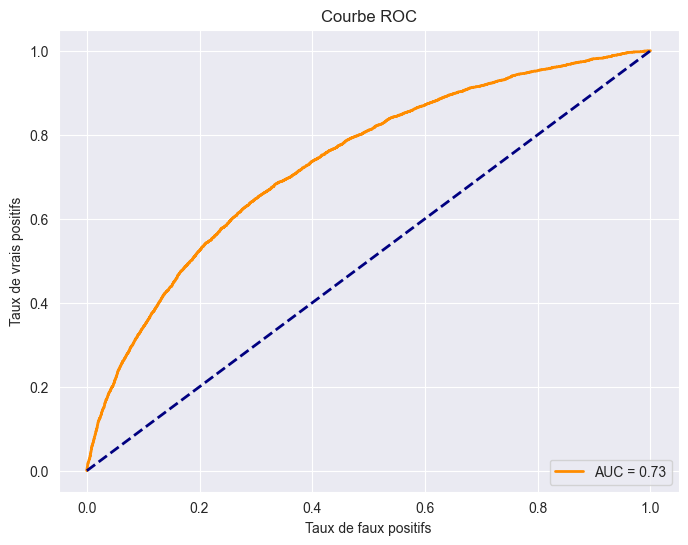

In [116]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


params = {'max_depth': 4, 'eta': 0.07740966888141193, 'gamma': 6.001629607781313e-08, 'colsample_bytree': 0.5742422067030846, 'subsample': 0.6205486721928506, 'n_estimators': 147, 'alpha': 0.33335092920540726}

# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

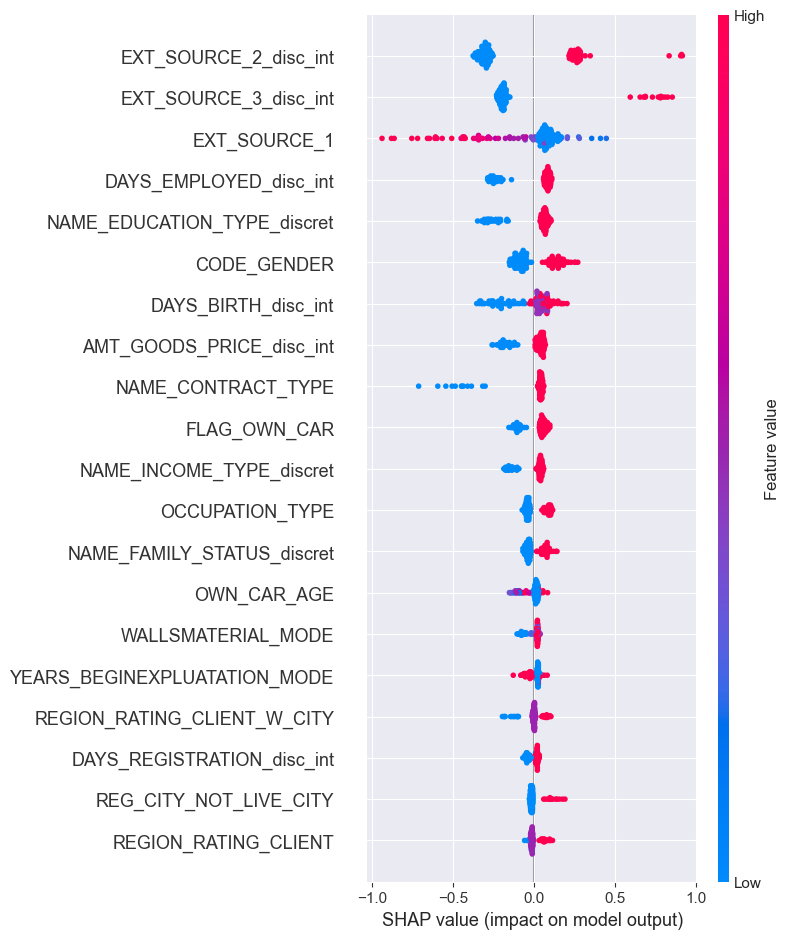

In [117]:
import shap


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train.iloc[:150, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train.iloc[:150, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[[0]])

In [120]:
X_train[['EXT_SOURCE_2_disc_int', 'EXT_SOURCE_3_disc_int', 'EXT_SOURCE_1',
       'DAYS_EMPLOYED_disc_int', 'NAME_EDUCATION_TYPE_discret']]

,EXT_SOURCE_2_disc_int,EXT_SOURCE_3_disc_int,EXT_SOURCE_1,DAYS_EMPLOYED_disc_int,NAME_EDUCATION_TYPE_discret
225777,0.052147,0.061948,0.741920,0.085019,0.084811
75431,0.103730,0.061948,0.000000,0.055238,0.084811
142076,0.052147,0.061948,0.772658,0.055238,0.084811
267377,0.052147,0.061948,0.540676,0.085019,0.050229
206594,0.103730,0.061948,0.000000,0.085019,0.050229
...,...,...,...,...,...
83042,0.052147,0.061948,0.000000,0.085019,0.084811
115620,0.103730,0.061948,0.000000,0.085019,0.084811
100817,0.052147,0.061948,0.000000,0.085019,0.084811
9260,0.052147,0.061948,0.000000,0.085019,0.084811


In [118]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 5
top_variables = X_train.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['EXT_SOURCE_2_disc_int', 'EXT_SOURCE_3_disc_int', 'EXT_SOURCE_1',
       'DAYS_EMPLOYED_disc_int', 'NAME_EDUCATION_TYPE_discret'],
      dtype='object')